# Gaussian Naive Bayes GNB CPU

In [1]:
import os
import pandas as pd
import numpy as np
import librosa
import parselmouth
from tqdm import tqdm
from scipy.stats import entropy
from scipy.signal import find_peaks

In [ ]:
def extract_features(y, sr):
    features = {}
    
    # Ensure minimum duration
    min_duration = 0.1  # 100 ms
    if len(y) / sr < min_duration:
        y = librosa.util.fix_length(y, size=int(min_duration * sr))
    
    # MFCC features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=512)
    features.update({f'mfcc_{i}': np.mean(mfcc) for i, mfcc in enumerate(mfccs)})
    
    # Delta and Delta-Delta MFCCs
    if mfccs.shape[1] >= 3:
        delta_mfccs = librosa.feature.delta(mfccs, mode='nearest')
        delta2_mfccs = librosa.feature.delta(mfccs, order=2, mode='nearest')
        features.update({f'delta_mfcc_{i}': np.mean(delta_mfcc) for i, delta_mfcc in enumerate(delta_mfccs)})
        features.update({f'delta2_mfcc_{i}': np.mean(delta2_mfcc) for i, delta2_mfcc in enumerate(delta2_mfccs)})
    else:
        features.update({f'delta_mfcc_{i}': 0 for i in range(13)})
        features.update({f'delta2_mfcc_{i}': 0 for i in range(13)})
    
    # Pitch (fundamental frequency)
    pitches, _ = librosa.piptrack(y=y, sr=sr)
    pitches = pitches[pitches > 0]
    if len(pitches) > 0:
        features['pitch_mean'] = np.mean(pitches)
        features['pitch_std'] = np.std(pitches)
        
        # Pitch Period Entropy (PPE)
        pitch_periods = 1 / pitches
        features['ppe'] = entropy(pitch_periods)
    else:
        features['pitch_mean'] = 0
        features['pitch_std'] = 0
        features['ppe'] = 0
    
    # Voice quality features (using Praat)
    try:
        point_process = parselmouth.praat.call(sound, "To PointProcess (periodic, cc)", 75, 600)
        jitter = parselmouth.praat.call(point_process, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
        shimmer = parselmouth.praat.call([sound, point_process], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
        hnr = parselmouth.praat.call(sound, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
        
        features['jitter'] = jitter
        features['shimmer'] = shimmer
        features['hnr_mean'] = np.mean(hnr.values)
    except:
        features['jitter'] = 0
        features['shimmer'] = 0
        features['hnr_mean'] = 0
    
    # Temporal features
    zero_crossings = librosa.zero_crossings(y)
    features['speech_rate'] = sum(zero_crossings) / len(y) * sr
    
    # Pause characteristics
    non_silent_intervals = librosa.effects.split(y, top_db=20)
    features['pause_count'] = max(0, len(non_silent_intervals) - 1)
    if features['pause_count'] > 0:
        features['pause_duration_mean'] = np.mean([interval[0] - non_silent_intervals[i-1][1] for i, interval in enumerate(non_silent_intervals[1:], 1)]) / sr
    else:
        features['pause_duration_mean'] = 0
    
    # Energy-based features
    rms = librosa.feature.rms(y=y)
    features['rms_mean'] = np.mean(rms)
    features['rms_std'] = np.std(rms)
    
    return features

In [ ]:
# Set the path to your dataset
dataset_path = 'dataset'

# Initialize list to hold features and labels
all_features = []
labels = []

# Iterate through each label (0 and 1)
for label in ['0', '1']:
    label_path = os.path.join(dataset_path, label)
    # Iterate through all WAV files in the label folder
    for file in tqdm(os.listdir(label_path), desc=f"Processing label {label}"):
        if file.endswith('.wav'):
            file_path = os.path.join(label_path, file)
            try:
                # Load the audio file
                y, sr = librosa.load(file_path, sr=None)
                # Extract features
                features = extract_features(y, sr)
                all_features.append(features)
                labels.append(int(label))
            except Exception as e:
                print(f"Error processing file {file}: {str(e)}")

# Create a DataFrame from the features and labels
features_df = pd.DataFrame(all_features)
features_df['label'] = labels

# Display the first few rows of the DataFrame
print(features_df.head())

# Export the DataFrame to a CSV file
output_csv_path = 'dysnet. csv'
features_df.to_csv(output_csv_path, index=False)
print(f"Dataset exported to {output_csv_path}")

In [2]:
# Now reading the CSV
df = pd.read_csv('dysnet.csv')
df.head(5)

,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,ppe,jitter,shimmer,hnr_mean,speech_rate,pause_count,pause_duration_mean,rms_mean,rms_std,label
0,-311.38477,26.980896,-9.236873,-3.446952,2.797759,-13.794222,-8.201365,-2.554216,-8.087993,-5.623301,...,8.679014,0.019937,0.152964,-135.471046,6536.470588,1,0.064000,0.016381,0.015243,0
1,-320.63364,31.162016,2.956488,9.534509,12.790990,-16.227764,-0.710162,-4.909526,-18.544220,2.431236,...,8.882021,0.017777,0.126177,-129.239224,5356.881720,15,0.241067,0.022353,0.021942,0
2,-300.99728,41.158607,-7.435174,7.761700,17.381987,-22.159197,-3.731641,-0.665727,-20.164322,-0.539192,...,8.686836,0.018722,0.109250,-113.387997,4946.394558,14,0.077714,0.025352,0.021311,0
3,-420.62094,-9.740299,35.861446,-1.680403,10.240573,-1.752196,1.488229,8.667743,-3.011296,0.726974,...,8.285378,0.096660,0.193904,-141.658091,9243.238095,0,0.000000,0.003137,0.002628,0
4,-288.11353,60.211166,10.757963,16.713995,21.329540,-10.454901,2.528886,-1.848374,-13.347257,7.410037,...,7.590672,0.041010,0.126378,-77.018103,2185.376344,0,0.000000,0.026444,0.014165,0


In [3]:
# check for null values
df.isnull().sum()

mfcc_0                 0
mfcc_1                 0
mfcc_2                 0
mfcc_3                 0
mfcc_4                 0
mfcc_5                 0
mfcc_6                 0
mfcc_7                 0
mfcc_8                 0
mfcc_9                 0
mfcc_10                0
mfcc_11                0
mfcc_12                0
delta_mfcc_0           0
delta_mfcc_1           0
delta_mfcc_2           0
delta_mfcc_3           0
delta_mfcc_4           0
delta_mfcc_5           0
delta_mfcc_6           0
delta_mfcc_7           0
delta_mfcc_8           0
delta_mfcc_9           0
delta_mfcc_10          0
delta_mfcc_11          0
delta_mfcc_12          0
delta2_mfcc_0          0
delta2_mfcc_1          0
delta2_mfcc_2          0
delta2_mfcc_3          0
delta2_mfcc_4          0
delta2_mfcc_5          0
delta2_mfcc_6          0
delta2_mfcc_7          0
delta2_mfcc_8          0
delta2_mfcc_9          0
delta2_mfcc_10         0
delta2_mfcc_11         0
delta2_mfcc_12         0
pitch_mean             0


In [9]:
# drop all the rows with missing values
df.dropna(inplace=True)

In [18]:
df.to_csv('dysnet.csv', index=False)

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
import joblib

X = df.drop('label', axis=1)
y = df['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', GaussianNB())
])

param_grid = {
    'classifier__var_smoothing': [1e-9, 1e-8, 1e-7]
}


# Initialize GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=3,
    n_jobs=-1,
    return_train_score=True
)

# Fit the model
grid_search.fit(X_train, y_train)

# Save the best model
best_model = grid_search.best_estimator_
joblib.dump(best_model, 'GNB.pkl')

Fitting 5 folds for each of 3 candidates, totalling 15 fits


['GNB.pkl']

In [6]:
# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.77      0.82     16180
           1       0.79      0.87      0.83     15932

    accuracy                           0.82     32112
   macro avg       0.83      0.82      0.82     32112
weighted avg       0.83      0.82      0.82     32112

[[12515  3665]
 [ 2002 13930]]


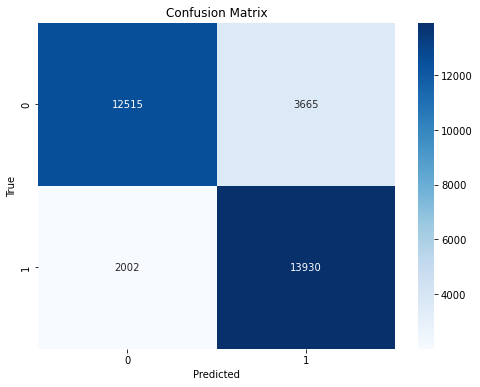

In [7]:
# plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [8]:
# Function to predict on new data
def predict_dysarthria(features):
    model = joblib.load('GNB.pkl')
    prediction = model.predict(features)
    return prediction

# Example of using the model with dummy data
def create_dummy_data(n_samples=1):
    feature_means = X.mean()
    feature_stds = X.std()
    dummy_data = pd.DataFrame(
        {col: np.random.normal(mean, std, n_samples) 
         for col, mean, std in zip(X.columns, feature_means, feature_stds)}
    )
    return dummy_data

# Test prediction with dummy data
dummy_data = create_dummy_data(5)
predictions = predict_dysarthria(dummy_data)

In [9]:
dummy_data

,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,pitch_std,ppe,jitter,shimmer,hnr_mean,speech_rate,pause_count,pause_duration_mean,rms_mean,rms_std
0,-361.786611,67.990127,-2.621896,37.540576,-17.206864,-3.327797,-10.969926,-4.244458,5.164486,-5.354679,...,963.901986,6.538811,0.035982,0.107038,-155.949819,3200.274208,0.145493,0.479339,0.061421,0.111376
1,-348.326758,70.465888,9.848167,-11.006514,-1.099127,23.276700,-17.607262,4.717106,-2.627145,-10.399570,...,1255.546096,6.291745,0.039212,0.074461,-114.322804,2231.754028,1.232764,0.288031,0.038885,0.091509
2,-412.389197,108.680200,7.126195,25.807031,3.848369,-7.944236,2.394037,-2.716604,-11.741844,-15.089397,...,1277.687593,6.767709,0.053501,0.094184,-150.457715,2721.994159,1.201215,0.280090,0.056080,0.062686
3,-421.080958,44.340638,12.941884,23.705268,2.439992,5.469232,-15.744165,4.758226,-5.976489,-2.236293,...,514.024874,6.928634,0.022287,0.094316,-117.186993,700.005306,2.178197,0.114063,0.091161,0.094066
4,-410.821932,32.234633,-4.094244,19.455677,-3.938492,1.910531,-16.396451,-0.863697,-15.955959,-4.478085,...,1042.066228,6.548529,0.009085,0.045616,-170.441587,2309.194414,0.708513,0.517001,0.080394,0.018838


In [10]:
predictions

array([0, 0, 0, 0, 0])

[CV 4/5] END classifier__var_smoothing=1e-07;, score=(train=0.823, test=0.825) total time=  41.1s
[CV 1/5] END classifier__var_smoothing=1e-09;, score=(train=0.824, test=0.822) total time=  43.1s
[CV 2/5] END classifier__var_smoothing=1e-09;, score=(train=0.824, test=0.820) total time=  42.7s
[CV 1/5] END classifier__var_smoothing=1e-08;, score=(train=0.824, test=0.822) total time=  42.2s
[CV 5/5] END classifier__var_smoothing=1e-09;, score=(train=0.823, test=0.824) total time=  41.8s
[CV 5/5] END classifier__var_smoothing=1e-07;, score=(train=0.823, test=0.824) total time=  41.4s
[CV 2/5] END classifier__var_smoothing=1e-07;, score=(train=0.824, test=0.820) total time=  44.0s
[CV 3/5] END classifier__var_smoothing=1e-08;, score=(train=0.823, test=0.825) total time=  41.8s
[CV 4/5] END classifier__var_smoothing=1e-08;, score=(train=0.823, test=0.825) total time=  42.6s
[CV 1/5] END classifier__var_smoothing=1e-07;, score=(train=0.824, test=0.822) total time=  45.7s
[CV 2/5] END classif